In [7]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
from matplotlib.colors import Normalize

from scipy.signal import find_peaks
from scipy import ndimage
from scipy.signal import savgol_filter
from scipy.stats import norm

from astropy.time import Time
from astropy.timeseries import LombScargle

import jax

# famously called out in DFM's AAS plenary *paints nails*
# (I didn't end up using george here after all but I want to keep it for the meme)
import george 
import celerite
import tinygp

import lightkurve as lk

import radvel
from radvel.plot import orbit_plots
from radvel.kepler import rv_drive
from radvel.orbit import timetrans_to_timeperi

# enable double precision in JAX
jax.config.update("jax_enable_x64", True)

### Loads the RV data

In [8]:
sm21_rvs = pd.read_csv(
    'data/RV_DATA.dat', sep='\s+', comment='#', 
    names=['time', 'mnvel','errvel', 'tel']
)
sm21_rvs.time -= 7000

# add in fitted jitter and gamma values from SM21 fit
sm21_rvs['errvel_withjit'] = sm21_rvs['errvel']
for i, jit_val in enumerate([3.05, -4.9, -4.7, -0.3]):
    sm21_rvs.loc[sm21_rvs.tel == i, 'errvel_withjit'] = np.sqrt(
        (sm21_rvs.loc[sm21_rvs.tel == i, 'errvel_withjit'].values)**2 +
        np.exp(jit_val)**2
    )
sm21_rvs['mnvel_withgamma'] = sm21_rvs['mnvel']
for i, gamma_val in enumerate([12, -34, -2, -16]):
    sm21_rvs.loc[sm21_rvs.tel == float(i), 'mnvel_withgamma'] += gamma_val

harps_rvs = sm21_rvs[sm21_rvs.tel == 0]
carm_rvs = sm21_rvs[sm21_rvs.tel == 1]

new_rvs = pd.read_csv('data/all_rvs.csv')
hires_rvs = new_rvs[new_rvs.tel == 'Keck']
hires_rvs.time -= 2457000
hires_rvs.mnvel -= np.median(hires_rvs.mnvel)

all_rvs = pd.concat([new_rvs, sm21_rvs])

times2plot = np.linspace(1400, 1950, int(1e4))

### Loads the LCO photometry

In [9]:
def normalize_lc(flux):
    """ Returns median-normalized flux in units of parts-per-thousand.
    Stolen from Adina Feinstein.
    """
    mu = np.nanmedian(flux)
    return (flux/mu - 1) * 1e3

# loads LCO data
lco_data = pd.read_csv(
    'data/LCO_DATA.dat', sep='\s+', comment='#', 
    names=['time', 'data', 'errors']
)
lco_data.time += 2450000 - 2457e3
lco_timespan = np.max(lco_data.time.values) - np.min(lco_data.time.values)

### Loads the K2 & TESS photometry

In [10]:
# loads K2 data
k2_lc = lk.search_lightcurve(
    "v1298 tau", author="EVEREST"
)[0].download().remove_nans().remove_outliers().normalize()
data = {
    "time": k2_lc.time.value + 2454833 - 2457e3, 
    "data":normalize_lc(k2_lc.flux.value), 
    "errors": 1e3 * np.sqrt(k2_lc.fraw.value) / np.mean(k2_lc.fraw.value)
} 
k2_data = pd.DataFrame(data)

# loads TESS data
temp1 = np.loadtxt('data/TESS_data/v1298_s43_o1_v2.txt')
temp2 = np.loadtxt('data/TESS_data/v1298_s43_o2_v2.txt')
temp3 = np.loadtxt('data/TESS_data/v1298_s44_o1_v1.txt')
temp4 = np.loadtxt('data/TESS_data/v1298_s44_o2_v1.txt')
temp1[:,1] = normalize_lc(temp1[:,2])
temp2[:,1] = normalize_lc(temp2[:,2])
temp3[:,1] = normalize_lc(temp3[:,2])
temp4[:,1] = normalize_lc(temp4[:,2])
temp = np.vstack((temp1, temp2, temp3, temp4))
data = {
    "time":Time(temp[:,0], format='mjd').jd - 2457e3, 
    "data":temp[:,1], 
    "errors":np.sqrt(temp[:,2]) / np.mean(temp[:,2]) * 1e3
}
tess_data = pd.DataFrame(data)

k2_timespan = np.max(k2_data.time.values) - np.min(k2_data.time.values)
tess_timespan = np.max(tess_data.time.values) - np.min(tess_data.time.values)

### Makes Figure 1: RV tour & new RV data table

1438.9463 & 387.47 & 7.88 \\
1443.8205 & -193.32 & 8.53 \\
1443.9573 & -87.96 & 7.94 \\
1443.9682 & -77.17 & 7.07 \\
1443.9792 & -92.67 & 8.61 \\
1444.1566 & -19.40 & 8.40 \\
1476.8089 & 190.28 & 11.71 \\
1479.0060 & 30.83 & 10.27 \\
1490.7912 & 246.54 & 10.05 \\
1491.7549 & 0.31 & 8.80 \\
1508.9196 & -56.33 & 9.53 \\
1509.7900 & 163.24 & 12.03 \\
1528.7841 & -58.17 & 9.75 \\
1532.7701 & -78.17 & 10.47 \\
1559.7316 & 261.44 & 9.53 \\
1568.7290 & -23.72 & 9.68 \\
1569.7376 & -94.99 & 11.02 \\
1723.1354 & -0.31 & 8.62 \\
1724.0917 & -26.27 & 9.65 \\
1733.0739 & -44.28 & 9.66 \\
1743.9965 & 37.42 & 10.46 \\
1765.9266 & -138.49 & 11.11 \\
1774.9154 & 287.77 & 9.43 \\
1777.0163 & 94.72 & 9.40 \\
1787.9817 & -239.82 & 10.01 \\
1794.8691 & 34.79 & 8.83 \\
1795.9062 & 95.70 & 8.25 \\
1796.9165 & -90.09 & 8.83 \\
1797.9532 & 292.26 & 8.13 \\
1845.8966 & 375.28 & 9.47 \\
1852.7705 & -259.55 & 9.59 \\
1855.8832 & -68.08 & 16.10 \\
1870.8459 & 318.54 & 8.90 \\
1879.8314 & 282.03 & 9.12 \\
1880.831

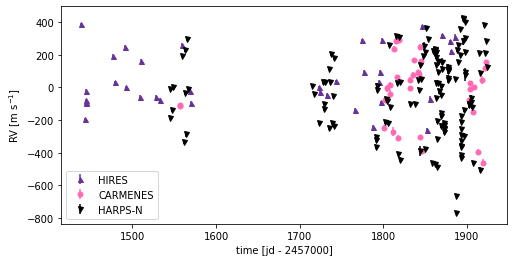

In [7]:
plt.figure(figsize=(8, 4))
plt.errorbar(
    hires_rvs.time, hires_rvs.mnvel, hires_rvs.errvel, linestyle='',  
    color='rebeccapurple', label='HIRES', marker='^'
)
plt.errorbar(
    carm_rvs.time, carm_rvs.mnvel, carm_rvs.errvel, linestyle='', 
    color='hotpink', label='CARMENES', marker='o'
)
plt.errorbar(
    harps_rvs.time, harps_rvs.mnvel, harps_rvs.errvel, linestyle='', 
    color='k', label='HARPS-N', marker='v'
)
plt.legend()
plt.xlabel('time [jd - 2457000]')
plt.ylabel('RV [m s$^{{-1}}$]')
plt.savefig('plots/rv_tour.png', dpi=250)

for i in np.arange(len(hires_rvs)):
    print(
        '{:.4f} & {:.2f} & {:.2f} \\\\'.format(
            hires_rvs.time[i], hires_rvs.mnvel[i], hires_rvs.errvel[i]
        )
    )

### Makes Figure 9: photometry tour

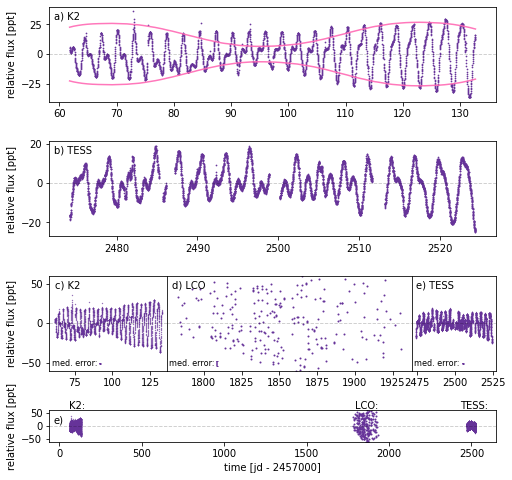

In [8]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(
    4, 3, figure=fig, height_ratios=[3, 3, 3, 1], wspace=0, hspace=0.5,
    width_ratios=[k2_timespan, lco_timespan, tess_timespan]
)

big_k2_ax = fig.add_subplot(gs[0,:])
big_k2_ax.scatter(k2_data.time, k2_data.data, s=0.5, color='rebeccapurple')
big_k2_ax.axhline(0, color='k', alpha=0.2, ls='--', lw=0.9)
big_k2_ax.text(0.01, 0.87, 'a) K2', transform=big_k2_ax.transAxes)
big_k2_ax.set_ylabel('relative flux [ppt]')

big_tess_ax = fig.add_subplot(gs[1,:])
big_tess_ax.scatter(tess_data.time, tess_data.data, s=0.5, color='rebeccapurple')
big_tess_ax.axhline(0, color='k', alpha=0.2, ls='--', lw=0.9)
big_tess_ax.text(0.01, 0.87, 'b) TESS', transform=big_tess_ax.transAxes)
big_tess_ax.set_ylabel('relative flux [ppt]')

k2_ax = fig.add_subplot(gs[2,0], ylim=[-60, 60])
k2_ax.set_ylabel('relative flux [ppt]')
k2_ax.text(0.05, 0.87, 'c) K2', transform=k2_ax.transAxes)

ls = LombScargle(k2_data.time.values, k2_data.data.values)
offset = ls.offset()
fit_284 = ls.model(k2_data.time.values, 1/2.85)
fit_300 = ls.model(k2_data.time.values, 1/3.00)
fit_269 = ls.model(k2_data.time.values, 1/2.70)

fourier_model = (fit_284 + fit_269 + fit_300)
max_model = savgol_filter(ndimage.maximum_filter1d(fourier_model, 200), 501, 3)

big_k2_ax.plot(
    k2_data.time, 
    max_model,
    color='hotpink', alpha=0.9
)
big_k2_ax.plot(
    k2_data.time, 
    -max_model,
    color='hotpink', alpha=0.9
)

lco_ax = fig.add_subplot(gs[2,1], ylim=[-60, 60], yticks=[])
lco_ax.text(0.02, 0.87, 'd) LCO', transform=lco_ax.transAxes)

tess_ax = fig.add_subplot(gs[2,2], ylim=[-60, 60], yticks=[])
tess_ax.text(0.05, 0.87, 'e) TESS', transform=tess_ax.transAxes)

all_data_ax = fig.add_subplot(gs[3,:])
all_data_ax.set_ylim(-60, 60)
all_data_ax.axhline(0, color='k', alpha=0.2, ls='--', lw=0.9)
all_data_ax.set_xlabel('time [jd - 2457000]')
all_data_ax.text(0.01, 0.6, 'e)', transform=all_data_ax.transAxes)
k2_ax.errorbar(
    [92], [-51], [np.median(k2_data.errors)], color='rebeccapurple', capsize=1
)
k2_ax.text(60, -54, 'med. error:', fontsize=8)
lco_ax.errorbar(
    [1809], [-51], [np.median(lco_data.errors)], color='rebeccapurple', capsize=1
)
lco_ax.text(1777, -54, 'med. error:', fontsize=8)
tess_ax.errorbar(
    [2505], [-51], [np.median(tess_data.errors)], color='rebeccapurple', 
    capsize=1
)
tess_ax.text(2473, -54, 'med. error:', fontsize=8)

all_data_ax.text(0.045, 1.05, 'K2:', transform=all_data_ax.transAxes)
all_data_ax.text(0.685, 1.05, 'LCO:', transform=all_data_ax.transAxes)
all_data_ax.text(0.92, 1.05, 'TESS:', transform=all_data_ax.transAxes)
all_data_ax.set_ylabel('relative flux [ppt]')

for ax in [all_data_ax, k2_ax]:
    ax.scatter(k2_data.time, k2_data.data, s=0.1, color='rebeccapurple')
for ax in [all_data_ax, lco_ax]:
    ax.scatter(lco_data.time, lco_data.data, s=1, color='rebeccapurple')
for ax in [all_data_ax, tess_ax]:
    ax.scatter(tess_data.time, tess_data.data, s=0.1, color='rebeccapurple')
for ax in [k2_ax, lco_ax, tess_ax]:
    ax.axhline(0, color='k', alpha=0.2, ls='--', lw=0.9)

plt.savefig('plots/photom.png', dpi=250)

### Makes Figure 10: Photometry Periodograms

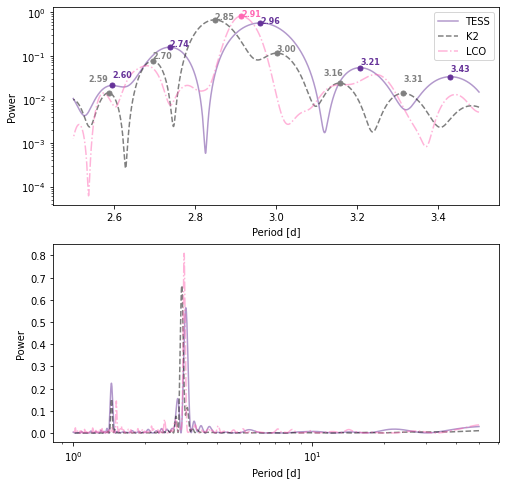

In [9]:
max_per = 3.5
min_per = 2.5

efap_threshold = .001

ls_k2 = LombScargle(
    k2_data.time.values, k2_data.data.values, k2_data.errors.values
)
efaps_k2 = ls_k2.false_alarm_level([efap_threshold])  

k2_freq, k2_power = ls_k2.autopower(
    minimum_frequency = 1 / max_per, maximum_frequency = 1 / min_per, 
    samples_per_peak=2000
)

ls_lco = LombScargle(
    lco_data.time.values, lco_data.data.values, lco_data.errors.values
)
lco_freq, lco_power = ls_lco.autopower(
    minimum_frequency = 1 / max_per, maximum_frequency = 1 / min_per, 
    samples_per_peak=2000
)
efaps_lco = ls_lco.false_alarm_level([efap_threshold])  

ls_tess = LombScargle(
    tess_data.time.values, tess_data.data.values, tess_data.errors.values
)
tess_freq, tess_power = ls_tess.autopower(
    minimum_frequency = 1 / max_per, maximum_frequency = 1 / min_per, 
    samples_per_peak=2000
)
efaps_tess = ls_tess.false_alarm_level([efap_threshold])  

# detect periodogram peaks
tess_peaks, peak_props = find_peaks(tess_power, height=efaps_tess[0])
tess_peak_heights = peak_props['peak_heights']

lco_peaks, peak_props = find_peaks(lco_power, height=efaps_lco[0])
lco_peak_heights = peak_props['peak_heights']

k2_peaks, peak_props = find_peaks(k2_power, height=efaps_k2[0])
k2_peak_heights = peak_props['peak_heights']

fig, axes = plt.subplots(2, 1, figsize=(8,8))
ax = axes[0]
plt.sca(ax)

plt.plot(
    1 / tess_freq, tess_power, label='TESS', color='rebeccapurple', alpha=0.5
)
plt.plot(
    1 / k2_freq, k2_power, label='K2', color='k', ls='--', alpha=0.5
)
plt.plot(
    1 / lco_freq, lco_power, label='LCO', color='hotpink', ls='-.', alpha=0.5
)
plt.scatter(1 / k2_freq[k2_peaks], k2_peak_heights, color='grey', zorder=10)
plt.scatter(1 / lco_freq[lco_peaks], lco_peak_heights, color='hotpink', zorder=10)
plt.scatter(
    1 / tess_freq[tess_peaks], tess_peak_heights, color='rebeccapurple', 
    zorder=10
)

for i, p in enumerate(tess_peaks):
    plt.text(
        1 / tess_freq[p], 
        0.012 + tess_peak_heights[i], 
        '{:.2f}'.format(1 / tess_freq[p]),
        fontdict={'size':8, 'color':'rebeccapurple', 'weight':'bold'}
    )
for i, p in enumerate(k2_peaks):
    if i != 5 and i != 1:
        plt.text(
            1 / k2_freq[p], 
            0.012 + k2_peak_heights[i], 
            '{:.2f}'.format(1 / k2_freq[p]),
            fontdict={'size':8, 'color':'grey', 'weight':'bold'}
        )
    elif i == 5:
        plt.text(
            1 / k2_freq[p] - .05, 
            0.012 + k2_peak_heights[i], 
            '{:.2f}'.format(1 / k2_freq[p]),
            fontdict={'size':8, 'color':'grey', 'weight':'bold'}
        )
    else:
        plt.text(
            1 / k2_freq[p] - .04, 
            0.012 + k2_peak_heights[i], 
            '{:.2f}'.format(1 / k2_freq[p]),
            fontdict={'size':8, 'color':'grey', 'weight':'bold'}
        )
for i, p in enumerate(lco_peaks):
    plt.text(
        1 / lco_freq[p], 
        0.012 + lco_peak_heights[i], 
        '{:.2f}'.format(1 / lco_freq[p]),
        fontdict={'size':8, 'color':'hotpink', 'weight':'bold'}
    )
plt.legend()
plt.xlabel('Period [d]')
plt.ylabel('Power')

max_per = 50
min_per = 1

k2_freq, k2_power = ls_k2.autopower(
    minimum_frequency = 1 / max_per, maximum_frequency = 1 / min_per, 
    samples_per_peak=2000
)

lco_freq, lco_power = ls_lco.autopower(
    minimum_frequency = 1 / max_per, maximum_frequency = 1 / min_per, 
    samples_per_peak=2000
)

tess_freq, tess_power = ls_tess.autopower(
    minimum_frequency = 1 / max_per, maximum_frequency = 1 / min_per, 
    samples_per_peak=2000
)

axes[1].plot(
    1 / tess_freq, tess_power, label='TESS', color='rebeccapurple', alpha=0.5
)
axes[1].plot(1 / k2_freq, k2_power, label='K2', color='k', ls='--', alpha=0.5)
axes[1].plot(
    1 / lco_freq, lco_power, label='LCO', color='hotpink', ls='-.', alpha=0.5
)
axes[1].set_xscale('log')
axes[1].set_xlabel('Period [d]')
axes[1].set_ylabel('Power')
axes[0].set_yscale('log')
plt.savefig('plots/periodogram.png', dpi=250)

### Makes Figures 6 & 7: SM21 data PSD & Phase-folded RVs & photometry

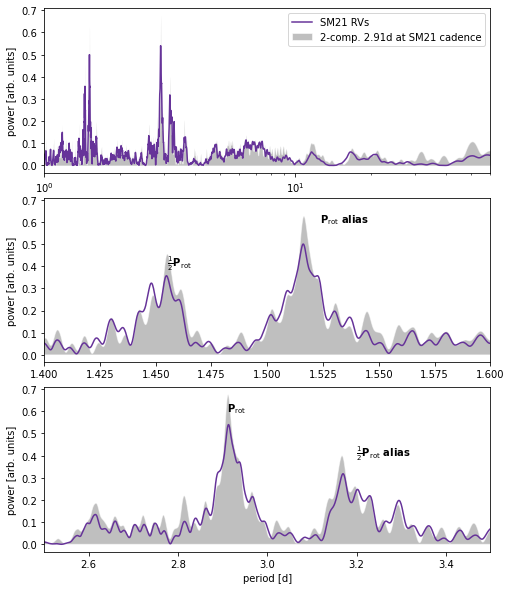

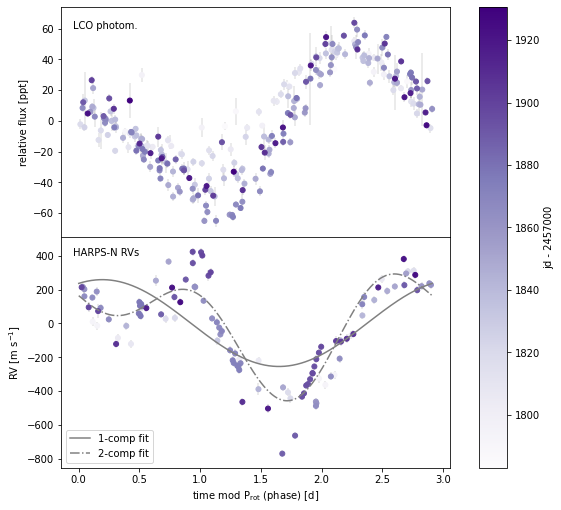

In [10]:
fig, ax = plt.subplots(3,1, figsize=(8,10))
plt.subplots_adjust(hspace=0.15)

freqs_for_ls = np.linspace(1 / 60, 1 / 1, int(1e4))
ls_data = LombScargle(
    sm21_rvs.time.values, sm21_rvs.mnvel.values, dy=sm21_rvs.errvel.values
)
power = ls_data.power(freqs_for_ls)
efaps = ls_data.false_alarm_level([0.0001 * 1e-2, 0.01 * 1e-2, 1e-2])  
for axis in ax:
    # axis.axhline(efaps[0], ls='--', color='grey', label='0.0001% eFAP')
    # axis.axhline(efaps[1], ls='--', color='grey', alpha=0.5, label='0.01% eFAP')
    # axis.axhline(efaps[2], ls='--', color='grey', alpha=0.25, label='1% eFAP')
    axis.set_ylabel('power [arb. units]')

for axis in ax:
    axis.plot(1/freqs_for_ls, power, color='rebeccapurple', label='SM21 RVs')
ax[2].set_xlabel('period [d]')

ax[0].set_xlim(1, 60)
ax[1].set_xlim(1.4, 1.6)
ax[2].set_xlim(2.5, 3.5)

# overplot a sinusoid with period 2.91d, sampled at SM21 cadence
ls_data_2term = LombScargle(
    sm21_rvs.time.values, sm21_rvs.mnvel.values, dy=sm21_rvs.errvel.values, 
    nterms=3
)
P_rot=2.91
modelparams_291 = ls_data_2term.model_parameters(1/P_rot)
fake_sine_data = (
    modelparams_291[0] + 
    modelparams_291[1] * np.sin(2 * np.pi * sm21_rvs.time.values / P_rot) +  
    modelparams_291[2] * np.cos(2 * np.pi * sm21_rvs.time.values / P_rot) + 
    modelparams_291[3] * np.sin(4 * np.pi * sm21_rvs.time.values / P_rot) +  
    modelparams_291[4] * np.cos(4 * np.pi * sm21_rvs.time.values / P_rot)
)
lspower_fakedata = LombScargle(
    sm21_rvs.time.values, fake_sine_data, dy=sm21_rvs.errvel.values
    ).power(
        freqs_for_ls
    )

for axis in ax:
    axis.fill_between(
        1/freqs_for_ls, 0 * freqs_for_ls, 
        lspower_fakedata, 
        color='grey', ec='white', alpha=0.5, label='2-comp. 2.91d at SM21 cadence'
    )

ax[0].legend()
ax[0].set_xscale('log')

# label Prot, Prot/2, and their aliases
ax[2].text(P_rot, 0.6, 'P$_{{\\mathrm{{rot}}}}$', fontdict={'fontweight':'bold'})
ax[1].text(
    P_rot/2, 0.4, '$\\frac{{1}}{{2}}$P$_{{\\mathrm{{rot}}}}$', 
    fontdict={'fontweight':'bold'}
)

ax[2].text(
    1/(1 - 1/(P_rot/2)), 0.4, '$\\frac{{1}}{{2}}$P$_{{\\mathrm{{rot}}}}$ alias', 
    fontdict={'fontweight':'bold'}
)
ax[1].text(
    1/(1 - 1/P_rot), 0.6, 'P$_{{\\mathrm{{rot}}}}$ alias', 
    fontdict={'fontweight':'bold'}
)

plt.savefig('plots/rvs_ls.png', dpi=250)

fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
plt.subplots_adjust(hspace=0)
plt.sca(ax[1])

norm = Normalize(vmin=lco_data.time.min(), vmax=lco_data.time.max())
cmap = cm.get_cmap('Purples')

phases2plot = np.linspace(0, 2.91, int(1e3))
twocomp_sinmodel = (
    modelparams_291[0] + 
    modelparams_291[1] * np.sin(2 * np.pi * phases2plot / P_rot) +  
    modelparams_291[2] * np.cos(2 * np.pi * phases2plot / P_rot) + 
    modelparams_291[3] * np.sin(4 * np.pi * phases2plot / P_rot) +  
    modelparams_291[4] * np.cos(4 * np.pi * phases2plot / P_rot)
)
onecomp_sinmodel = (
    modelparams_291[0] + 
    modelparams_291[1] * np.sin(2 * np.pi * phases2plot / P_rot) +  
    modelparams_291[2] * np.cos(2 * np.pi * phases2plot / P_rot)
)

plt.scatter(
    harps_rvs.time[harps_rvs.time > lco_data.time.min()] % 2.91, 
    harps_rvs.mnvel[harps_rvs.time > lco_data.time.min()], 
    c=cmap(norm(harps_rvs.time[harps_rvs.time > lco_data.time.min()]))
)
plt.errorbar(
    harps_rvs.time[harps_rvs.time > lco_data.time.min()] % 2.91, 
    harps_rvs.mnvel[harps_rvs.time > lco_data.time.min()], 
    harps_rvs.errvel_withjit[harps_rvs.time > lco_data.time.min()], 
    ls='', marker='', color='k', alpha=0.1, zorder=0
)
plt.plot(
    phases2plot, onecomp_sinmodel, color='grey', ls='-', label='1-comp fit'
)
plt.plot(phases2plot, twocomp_sinmodel, color='grey', ls='-.', label='2-comp fit')
plt.legend(loc='lower left')
plt.ylabel('RV [m s$^{{-1}}$]')
plt.xlabel('time mod P$_{{\\mathrm{{rot}}}}$ (phase) [d]')
plt.text(-.05, 400, 'HARPS-N RVs')


plt.sca(ax[0])
plt.ylabel('relative flux [ppt]')
plt.scatter(lco_data.time % 2.91, lco_data.data, c=cmap(norm(lco_data.time)))
plt.errorbar(
    lco_data.time % 2.91, lco_data.data, lco_data.errors, ls='', marker='', 
    color='k', alpha=0.1, zorder=0
)
plt.text(-.05, 60, 'LCO photom.')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.05, 0.8])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
plt.ylabel('jd - 2457000')

plt.savefig('plots/rv_2compfit.png', dpi=250)

### Makes Figures 11 & 12: RadVel plots with and without assuming diff. datasets are correlated

Note: must run the following cell before either of the next two.

In [4]:
def build_gp_post(correlated=False):

    # this code follows the RadVel GP tutorial, using K2-131 data from Dai+ (2017)

    data = pd.read_csv(os.path.join(radvel.DATADIR,'k2-131.txt'), sep=' ')

    t = np.array(data.time)
    vel = np.array(data.mnvel)
    errvel = np.array(data.errvel)
    tel = np.array(data.tel)

    telgrps = data.groupby('tel').groups
    instnames = telgrps.keys()

    hnames = [ # (this data structure is unused by the updated version of radvel)
        'gp_amp', # variability amplitude
        'gp_amp', # variability amplitude
        'gp_explength', # exponential decay timescale
        'gp_per', # variability period
        'gp_perlength', # shape parameter
    ]

    gp_explength_mean = 9.5*np.sqrt(2.) # sqrt(2)*tau in Dai+ 2017 [days]
    gp_perlength_mean = np.sqrt(1./(2.*3.32)) # sqrt(1/(2*gamma)) in Dai+ 2017
    gp_per_mean = 9.64 # T_bar in Dai+ 2017 [days]

    Porb = 0.3693038 # orbital period [days]
    Tc = 2457582.9360 # [BJD]

    nplanets=1
    params = radvel.Parameters(nplanets,basis='per tc secosw sesinw k')

    params['per1'] = radvel.Parameter(value=Porb)
    params['tc1'] = radvel.Parameter(value=Tc)
    params['sesinw1'] = radvel.Parameter(value=0.,vary=False) # fix eccentricity = 0
    params['secosw1'] = radvel.Parameter(value=0.,vary=False)
    params['k1'] = radvel.Parameter(value=6.55)
    params['dvdt'] = radvel.Parameter(value=0.,vary=False)
    params['curv'] = radvel.Parameter(value=0.,vary=False)

    if correlated:
        params['gp_amp_harps-n'] = radvel.Parameter(value=25.0)
        params['gp_amp_pfs'] = radvel.Parameter(value=25.0)
    else:
        params['gp_amp'] = radvel.Parameter(value=25.0)
    params['gp_explength'] = radvel.Parameter(value=gp_explength_mean) 
    params['gp_per'] = radvel.Parameter(value=gp_per_mean) 
    params['gp_perlength'] = radvel.Parameter(value=gp_perlength_mean)

    gpmodel = radvel.model.RVModel(params)

    jit_guesses = {'harps-n':0.5, 'pfs':5.0}

    likes = []
    def initialize(tel_suffix):

        # Instantiate a separate likelihood object for each instrument.
        # Each likelihood must use the same radvel.RVModel object.
        indices = telgrps[tel_suffix]
        if correlated:
            like = radvel.likelihood.RVLikelihood(
                gpmodel, t[indices], vel[indices], 
                errvel[indices], suffix='_'+tel_suffix
            )
        else:
            like = radvel.likelihood.GPLikelihood(
                gpmodel, t[indices], vel[indices], 
                errvel[indices], hnames, suffix='_'+tel_suffix,
                kernel_name="QuasiPer"
            )
        # Add in instrument parameters
        like.params['gamma_'+tel_suffix] = radvel.Parameter(value=np.mean(vel[indices]))
        like.params['jit_'+tel_suffix] = radvel.Parameter(value=jit_guesses[tel_suffix]) 
        likes.append(like)

    for tel in instnames:
        initialize(tel)

    if correlated:
        gplike = radvel.likelihood.GPLikelihood(likes)
    else:
        gplike = radvel.likelihood.CompositeLikelihood(likes)
    gppost = radvel.posterior.Posterior(gplike)

    return gppost

Already on 'master'
Your branch is up to date with 'origin/master'.

[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
RadVel version: 1.4.9


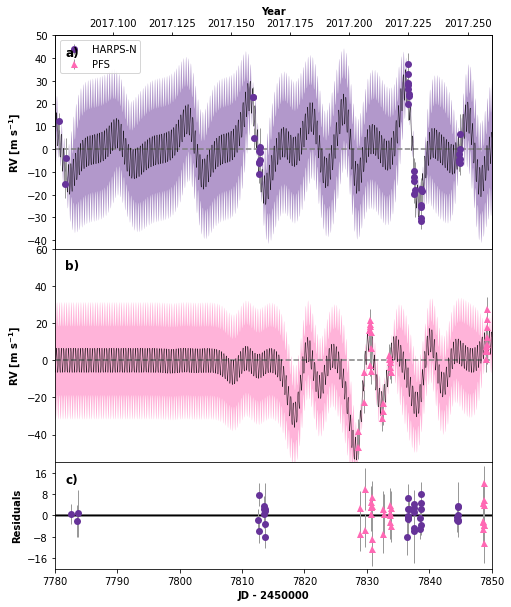

In [4]:
"""
Figure 11: uncorrelated datasets
"""

radvel_path = '/home/sblunt/Projects/radvel'

# change to & install the local radvel copy for now
current_path = os.getcwd()
os.chdir(radvel_path)
!git checkout master
%pip install -q . --upgrade
os.chdir(current_path)

print('RadVel version: {}'.format(radvel.__version__))

# first make a plot with a previous version of RadVel, assuming data from
# diff instruments are uncorrelated 
GPPlot = orbit_plots.GPMultipanelPlot(
    build_gp_post(),
    subtract_gp_mean_model=False,
    plot_likelihoods_separately=True, 
    subtract_orbit_model=False,
    set_xlim=[7780,7850], 
    telfmts={
        'harps-n': dict(fmt='o', color='rebeccapurple', ms=7),
        'pfs': dict(fmt='^', color='hotpink', ms=7)
    }
) 
fig, ax = GPPlot.plot_multipanel(nophase=True)

ax[0].lines[1].set_color('k')
ax[1].lines[1].set_color('k')
ax[2].lines[0].set_color('k')

# remove the PFS points from the HARPS-N panel and vice versa
# (this is a little hacky, apologies)
del ax[0].lines[3]
del ax[0].collections[2]

del ax[1].lines[2]
del ax[1].collections[1]

plt.savefig('plots/indep.png', dpi=250)

Already on 'tinygp'
Your branch is up to date with 'origin/tinygp'.

[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
RadVel version: 1.4.9


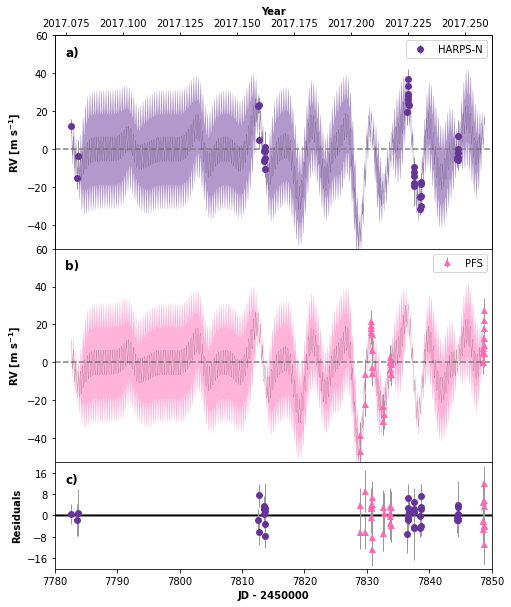

In [5]:
"""
Figure 12: correlated datasets
"""

radvel_path = '/home/sblunt/Projects/radvel'

# change to & install the local radvel copy for now
current_path = os.getcwd()
os.chdir(radvel_path)
!git checkout tinygp
%pip install -q . --upgrade
os.chdir(current_path)

print('RadVel version: {}'.format(radvel.__version__))

# now make a plot with the (in prep) tinygp version of RadVel, assuming data from
# diff instruments are correlated 
GPPlot = orbit_plots.GPMultipanelPlot(
    build_gp_post(correlated=True),
    set_xlim=[7780,7850], 
    telfmts={
        'harps-n': dict(fmt='o', color='rebeccapurple', ms=7),
        'pfs': dict(fmt='^', color='hotpink', ms=7)
    }
) 
fig, ax = GPPlot.plot_multipanel(nophase=True)

ax[0].lines[1].set_color('k')
ax[1].lines[1].set_color('k')
ax[2].lines[0].set_color('k')

plt.savefig('plots/multiplied.png', dpi=250)

### Reproduces the SM21 Best Fit
(needed for all subsequent plots)

In [11]:
freqs_for_ls = np.logspace(np.log(1 / 500), np.log(1 / 1), int(1e4))

# best-fit params from adopted SM21 fit
P_rot = 2.9101
ln_C = -5.5
C = np.exp(ln_C)
ln_A = 5.53
A = np.exp(ln_A)
ln_mix = -0.19 # delta, I believe
mix = np.exp(ln_mix)
L1 = np.exp(5.34)
L2 =  np.exp(4.98)

def cosine(x):
    return (
        celerite.terms.ComplexTerm(
            log_a=np.log(1), log_b=np.log(0), log_c=np.log(0), log_d=np.log(x)
        ) 
    )
def const_term(x):
    return celerite.terms.RealTerm(log_a=np.log(x), log_c = np.log(0))

kernel = const_term(A**2 / (2 + C)) * (
    (
        celerite.terms.RealTerm(
            log_a=np.log(1), 
            log_c=np.log(1/L1)
        ) * (const_term(1+C) + cosine(2 * np.pi / P_rot))
    ) + const_term(mix**2) * (
        celerite.terms.RealTerm(
            log_a=np.log(1), 
            log_c=np.log(1/L2)
        ) * (const_term(1+C) + cosine(4 * np.pi / P_rot))
    )
)
ang_freqs = np.linspace(1 / 60, 1 / 1, int(1e4))*(2*np.pi)
psd = kernel.get_psd(ang_freqs)

gp = celerite.GP(kernel)
errs2plot = np.ones(len(times2plot))
gp.compute(times2plot, errs2plot)
# prior_samples = gp.sample(5)

class PlMeanModel(celerite.modeling.Model):

    parameter_names = ()

    def get_value(self, t):
        p_b = 24.1399
        ecc_b = .31**2 + .06**2
        omega_b = np.arctan2(-.06, .31)
        tp_b = timetrans_to_timeperi(7067 - 7000, p_b, ecc_b, omega_b)
        b_rv = rv_drive(t, [p_b, tp_b, ecc_b, omega_b, 41])

        p_e = np.exp(3.693)
        ecc_e = .22**2 + .03**2
        omega_e = np.arctan2(-.03, .22)
        tp_e = timetrans_to_timeperi(7096 - 7000, p_e, ecc_e, omega_e)
        e_rv = rv_drive(t, [p_e, tp_e, ecc_e, omega_e, 62])
        return b_rv + e_rv

    def get_b_value(self, t):
        p_b = 24.1399
        ecc_b = .31**2 + .06**2
        omega_b = np.arctan2(-.06, .31)
        tp_b = timetrans_to_timeperi(7067 - 7000, p_b, ecc_b, omega_b)
        b_rv = rv_drive(t, [p_b, tp_b, ecc_b, omega_b, 41])
        return b_rv 

    def get_e_value(self, t):
        p_e = np.exp(3.693)
        ecc_e = .22**2 + .03**2
        omega_e = np.arctan2(-.03, .22)
        tp_e = timetrans_to_timeperi(7096 - 7000, p_e, ecc_e, omega_e)
        e_rv = rv_drive(t, [p_e, tp_e, ecc_e, omega_e, 62])
        return e_rv 


mean_model = PlMeanModel()
gp = celerite.GP(kernel, mean=mean_model, fit_mean=False)
gp.compute(harps_rvs.time.values, harps_rvs.errvel_withjit.values)
mu_plot, var_plot = gp.predict(harps_rvs.mnvel_withgamma, times2plot, return_var=True)
mu_predict, var_predict = gp.predict(
    harps_rvs.mnvel_withgamma, harps_rvs.time.values, return_var=True
)

# subtract off GP prediction, which includes activity mean and Keplerian 
# mean, then add back Keplerian mean
pl_only = harps_rvs.mnvel_withgamma - mu_predict + mean_model.get_value(
    harps_rvs.time.values
)
activity_only = mu_predict - mean_model.get_value(
    harps_rvs.time.values
)

### Makes Figure 8: Smoothed Activity Fit & Keplerians 

Time filtered over: 11.17 d


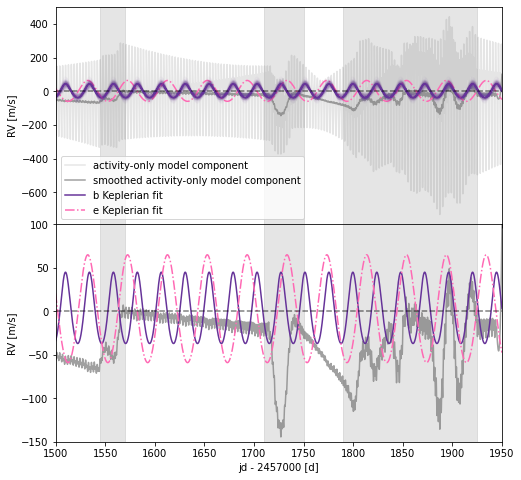

In [12]:
fig, ax = plt.subplots(2,1, figsize=(8,8), sharex=True)
plt.subplots_adjust(hspace=0)

# plot the activity-only prediction, smoothed over a few day timescale
filter_window_size = 203 # [# of array indices to smooth over]
filter_polynomial_order = 3
dt = (times2plot[1] - times2plot[0])
print('Time filtered over: {:.2f} d'.format(filter_window_size * dt ))

ax[0].plot(
    times2plot, mu_plot - mean_model.get_value(times2plot), color='grey', 
    alpha=0.2, label='activity-only model component'
)

for a in ax:
    a.plot(
        times2plot, 
        savgol_filter(
            mu_plot, filter_window_size, 
            filter_polynomial_order
        ) - mean_model.get_value(times2plot),  
        alpha=0.75, color='grey', label='smoothed activity-only model component'
    )
    a.plot(
        times2plot, mean_model.get_b_value(times2plot), color='rebeccapurple', 
        label='b Keplerian fit'
    )
    a.plot(
        times2plot, mean_model.get_e_value(times2plot), color='hotpink', ls='-.', 
        label='e Keplerian fit'
    )

"""
Approximate the posterior over e and b parameters
"""
def b_value(t, num_samples=100):
    p_b = np.random.normal(24.1399, .0015, size=num_samples)
    secosw = np.random.normal(.31, .16, size=num_samples)
    sesinw = np.random.normal(-.06, .17, size=num_samples)
    ecc_b = secosw**2 + sesinw**2
    omega_b = np.arctan2(sesinw, secosw)
    tc = np.random.normal(7067.0486, .0016, size=num_samples)
    tp_b = timetrans_to_timeperi(tc - 7000, p_b, ecc_b, omega_b)
    k = np.random.normal(41, 12, size=num_samples)
    b_rv = np.zeros((num_samples, len(t)))
    for i in range(num_samples):
        b_rv[i, :] = rv_drive(t, [p_b[i], tp_b[i], ecc_b[i], omega_b[i], k[i]])
    return b_rv 
def e_value(t, num_samples=100):
    p_e = np.exp(np.random.normal(3.693, .023, size=num_samples))
    secosw = np.random.normal(.22, .25, size=num_samples)
    sesinw = np.random.normal(-.03, .2, size=num_samples)
    ecc_e = secosw**2 + sesinw**2
    omega_e = np.arctan2(sesinw, secosw)
    tc = np.random.normal(7096.6227, .0033, size=num_samples)
    tp_e = timetrans_to_timeperi(tc - 7000, p_e, ecc_e, omega_e)
    k = np.random.normal(62, 16, size=num_samples)
    e_rv = np.zeros((num_samples, len(t)))
    for i in range(num_samples):
        e_rv[i, :] = rv_drive(t, [p_e[i], tp_e[i], ecc_e[i], omega_e[i], k[i]])
    return e_rv 

b_predictions = b_value(times2plot, num_samples=100)
e_predictions = e_value(times2plot, num_samples=100)
for i in range(len(b_predictions)):
    ax[0].plot(times2plot, b_predictions[i], color='rebeccapurple', alpha=0.03)

ax[0].axhline(0, ls='--', color='k', alpha=0.5)
for a in ax:
    a.axvspan(np.min(harps_rvs.time.values), 1570, color='grey', alpha=0.2)
    a.axvspan(1710, 1750, color='grey', alpha=0.2)
    a.axvspan(1790, np.max(harps_rvs.time.values), color='grey', alpha=0.2)
ax[1].set_xlabel('jd - 2457000 [d]')
ax[0].set_ylabel('RV [m/s]')
ax[1].set_ylabel('RV [m/s]')
ax[1].set_ylim(-150, 100)
ax[0].legend()
ax[0].set_xlim(1500, 1950)
ax[1].axhline(0, color='k', ls='--', alpha=0.5)

plt.savefig('plots/activity_difference.png', dpi=250)

### Makes Figures 2 & 3: HIRES & CARMENES prediction

[  0.75962081 -70.49081075]
chi2 of un-offset fit:
128.52510293676448
chi2 of offset fit:
65.96246549735504


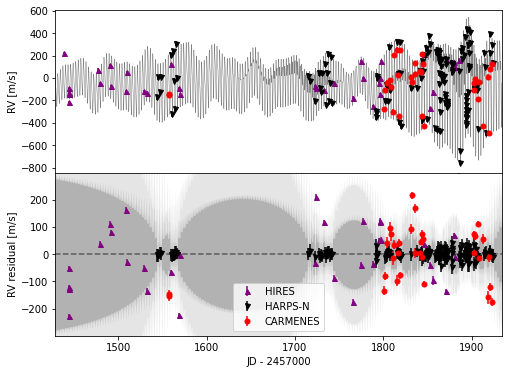

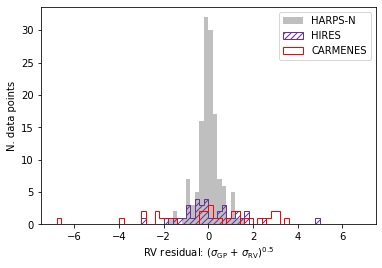

In [13]:
# CARM and HARPS have exactly the same fitted activity amplitude in SM21, so I 
# don't bother scaling the CARM RVs.

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
plt.subplots_adjust(hspace=0)
ax[0].plot(times2plot, mu_plot, color='k', alpha=0.5, lw=0.5)

mu_predict_hires, var_predict_hires = gp.predict(
    harps_rvs.mnvel_withgamma, hires_rvs.time.values, return_var=True
)
mu_predict_carm, var_predict_carm = gp.predict(
    harps_rvs.mnvel_withgamma, carm_rvs.time.values, return_var=True
)

total_err = np.sqrt(var_predict_hires + hires_rvs.errvel.values**2)
total_err_carm = np.sqrt(var_predict_carm + carm_rvs.errvel_withjit.values**2)

p = np.polyfit(hires_rvs.mnvel.values, mu_predict_hires, 1, w = 1/total_err**2)
print(p)

bestfit_hires_model = hires_rvs.mnvel.values * p[0] + p[1] 

print('chi2 of un-offset fit:')
print(np.sum(((mu_predict_hires - hires_rvs.mnvel.values)/total_err)**2))
print('chi2 of offset fit:')
print(np.sum(((mu_predict_hires - bestfit_hires_model)/total_err)**2))

ax[0].errorbar(
    hires_rvs.time, bestfit_hires_model, hires_rvs.errvel.values, 
    color='purple', ls='', marker='^', ms=5
)
ax[0].errorbar(
    harps_rvs.time, harps_rvs.mnvel_withgamma, harps_rvs.errvel_withjit, 
    color='k', ls='', marker='v', ms=5
)
ax[0].errorbar(
    carm_rvs.time, carm_rvs.mnvel_withgamma, carm_rvs.errvel_withjit, 
    color='red', ls='', marker='o', ms=5
)

ax[1].fill_between(
    times2plot, np.sqrt(var_plot), -np.sqrt(var_plot), 
    color='grey', alpha=0.5, ec='white'
)
ax[1].fill_between(
    times2plot, 2* np.sqrt(var_plot), -2* np.sqrt(var_plot), 
    color='grey', alpha=0.2, ec='white'
)
ax[1].errorbar(
    hires_rvs.time, bestfit_hires_model - mu_predict_hires, 
    hires_rvs.errvel.values, 
    color='purple', ls='', marker='^', ms=5, label='HIRES'
)
ax[1].errorbar(
    harps_rvs.time, harps_rvs.mnvel_withgamma.values - mu_predict, 
    harps_rvs.errvel_withjit, color='k', ls='', marker='v', ms=5, label='HARPS-N'
)
ax[1].errorbar(
    carm_rvs.time, carm_rvs.mnvel_withgamma.values - mu_predict_carm, 
    carm_rvs.errvel_withjit, color='red', ls='', marker='o', ms=5, label='CARMENES'
)
ax[1].legend()

plt.xlabel('JD - 2457000')
ax[0].set_ylabel('RV [m/s]')
ax[1].set_ylabel('RV residual [m/s]')
ax[1].set_xlim(1700, 1950)
ax[1].set_ylim(-300, 300)
ax[1].axhline(0, ls='--', color='k', alpha=0.5)
ax[1].set_yticks([-200, -100, 0, 100, 200])
plt.xlim(np.min(hires_rvs.time) - 10, np.max(harps_rvs.time) + 10)
plt.savefig('plots/hires_predict.png', dpi=250)

harps_total_err = np.sqrt(var_predict + harps_rvs.errvel_withjit**2)

plt.figure()
plt.hist(
    ((harps_rvs.mnvel_withgamma.values - mu_predict)/harps_total_err), 
    range=(-10, 10), bins=100, color='grey', alpha=0.5, ec='None', label='HARPS-N'
)
plt.hist(
    ((bestfit_hires_model - mu_predict_hires)/total_err), 
    range=(-10, 10), bins=100, ec='rebeccapurple', label='HIRES', histtype='step', 
    hatch='////'
)
plt.hist(
    ((carm_rvs.mnvel_withgamma.values - mu_predict_carm)/total_err_carm), 
    range=(-10, 10), bins=100, color='white', ec='red', label='CARMENES', 
    histtype='step'
)

plt.ylabel('N. data points')
plt.xlabel(
    'RV residual: ($\sigma_{{\\mathrm{{GP}}}}$ + $\sigma_{{\\mathrm{{RV}}}}$)$^{0.5}$'
)
plt.legend()
plt.xlim(-7.5, 7.5)
plt.savefig('plots/hires_overfitting.png', dpi=250)

### Makes Figures 4 & 5: HARPS-only prediction

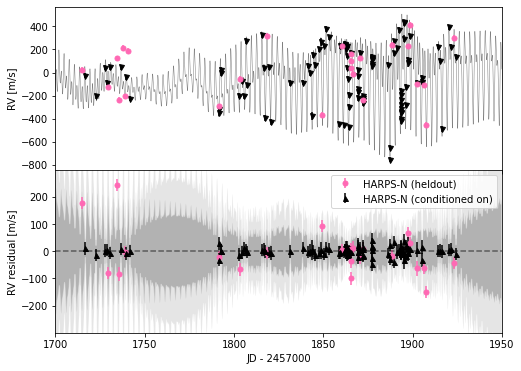

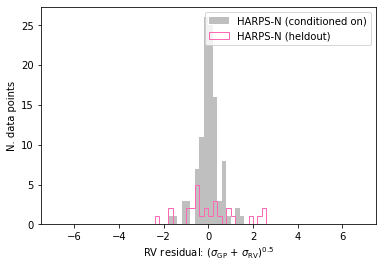

In [14]:
np.random.seed(13)

# do the above again, but condition the GP on some of the HARPs points and predict the held out percent

# select a random subset of the HARPS points to use for conditioning the GP
training_sample = np.sort(
    np.random.choice(len(harps_rvs), replace=False, size=int(0.8 * len(harps_rvs)))
)
times_train = harps_rvs.time.values[training_sample]
rvs_train = harps_rvs.mnvel_withgamma.values[training_sample]
errs_train = harps_rvs.errvel_withjit.values[training_sample]

holdout_sample = np.setdiff1d(np.arange(len(harps_rvs)), training_sample)
times_heldout = harps_rvs.time.values[holdout_sample]
rvs_heldout = harps_rvs.mnvel_withgamma.values[holdout_sample]
errs_heldout = harps_rvs.errvel_withjit.values[holdout_sample]

gp.compute(times_train, errs_train)
mu_plot_80percent, var_plot_80percent = gp.predict(
    rvs_train, times2plot, return_var=True
)
mu_predict_80percent, var_predict_80percent = gp.predict(
    rvs_train, harps_rvs.time.values, return_var=True
)

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
plt.subplots_adjust(hspace=0)
ax[0].plot(times2plot, mu_plot_80percent, color='k', alpha=0.5, lw=0.5)
ax[0].errorbar(
    times_train, rvs_train, 
    errs_train, color='k', ls='', marker='v', ms=5, label='HARPS-N'
)
ax[0].errorbar(
    times_heldout, rvs_heldout, 
    errs_heldout, color='hotpink', ls='', marker='o', ms=5, label='HARPS-N (heldout)'
)

ax[1].fill_between(
    times2plot, np.sqrt(var_plot_80percent), -np.sqrt(var_plot_80percent), 
    color='grey', alpha=0.5, ec='white'
)
ax[1].fill_between(
    times2plot, 2* np.sqrt(var_plot_80percent), -2* np.sqrt(var_plot_80percent), 
    color='grey', alpha=0.2, ec='white'
)

ax[1].errorbar(
    times_heldout, rvs_heldout - mu_predict_80percent[holdout_sample], 
    errs_heldout, color='hotpink', ls='', marker='o', ms=5, label='HARPS-N (heldout)'
)
ax[1].errorbar(
    times_train, rvs_train - mu_predict_80percent[training_sample], 
    errs_train, color='k', ls='', marker='^', ms=5, label='HARPS-N (conditioned on)'
)
ax[1].legend()
plt.xlabel('JD - 2457000')
ax[0].set_ylabel('RV [m/s]')
ax[1].set_ylabel('RV residual [m/s]')
ax[1].set_xlim(1700, 1950)
ax[1].set_ylim(-300, 300)
ax[1].axhline(0, ls='--', color='k', alpha=0.5)
ax[1].set_yticks([-200, -100, 0, 100, 200])
plt.savefig('plots/harps_predict.png', dpi=250)

plt.figure()

train_total_err = np.sqrt(var_predict_80percent[training_sample] + errs_train**2)
holdout_total_err = np.sqrt(var_predict_80percent[holdout_sample] + errs_heldout**2)

plt.hist(
    ((rvs_train - mu_predict_80percent[training_sample])/train_total_err), 
    range=(-10, 10), bins=100, color='grey', alpha=0.5, ec='None', 
    label='HARPS-N (conditioned on)'
)
plt.hist(
    ((rvs_heldout - mu_predict_80percent[holdout_sample])/holdout_total_err), 
    range=(-10, 10), bins=100, ec='hotpink', label='HARPS-N (heldout)', histtype='step'
)

plt.ylabel('N. data points')
plt.xlabel(
    'RV residual: ($\sigma_{{\\mathrm{{GP}}}}$ + $\sigma_{{\\mathrm{{RV}}}}$)$^{0.5}$'
)
plt.legend()
plt.xlim(-7.5, 7.5)
plt.savefig('plots/harps_overfitting.png', dpi=250)